# **Transfer learning / fine-tuning**



In [ ]:
import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation,GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

### **Importando o DATASET**

In [ ]:
(imagens, labels), _ = datasets.cifar10.load_data()

In [ ]:
imagens.shape

(50000, 32, 32, 3)

In [ ]:
nomes_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
num_classes = 10

## **Pré-Processamento, Separação entre treino, validação e teste e Visualização das Imagens**

In [ ]:
# Primeiro separamos 30% do conjunto original em 'temp' (será dividido em val+test)
# Sobram 70% → treino; temp (15% val + 15% test) = 30%
x_train, x_temp, y_train, y_temp = train_test_split(
    imagens, labels,
    test_size=0.30,
    random_state=42,
    stratify=labels
)


# seperando o conjunto de teste em 15% para teste e 15% para validação
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp,
    test_size=0.50,   # metade de 30% = 15%
    random_state=42,
    stratify=y_temp
)

print("Train:", x_train.shape, y_train.shape)
print("Val:  ", x_val.shape,   y_val.shape)
print("Test: ", x_test.shape,  y_test.shape)

Train: (35000, 32, 32, 3) (35000, 1)
Val:   (7500, 32, 32, 3) (7500, 1)
Test:  (7500, 32, 32, 3) (7500, 1)


In [ ]:
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_val_one_hot = to_categorical(y_val, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

print("One-hot encoded y_train shape:", y_train_one_hot.shape)

One-hot encoded y_train shape: (35000, 10)


In [ ]:
# Normalizando os valores dos pixels para que os dados fiquem na mesma escala
x_train = x_train / 255.0
x_test = x_test / 255.0
x_val = x_val / 255.0


# **Imagens do Conjunto de Treino**

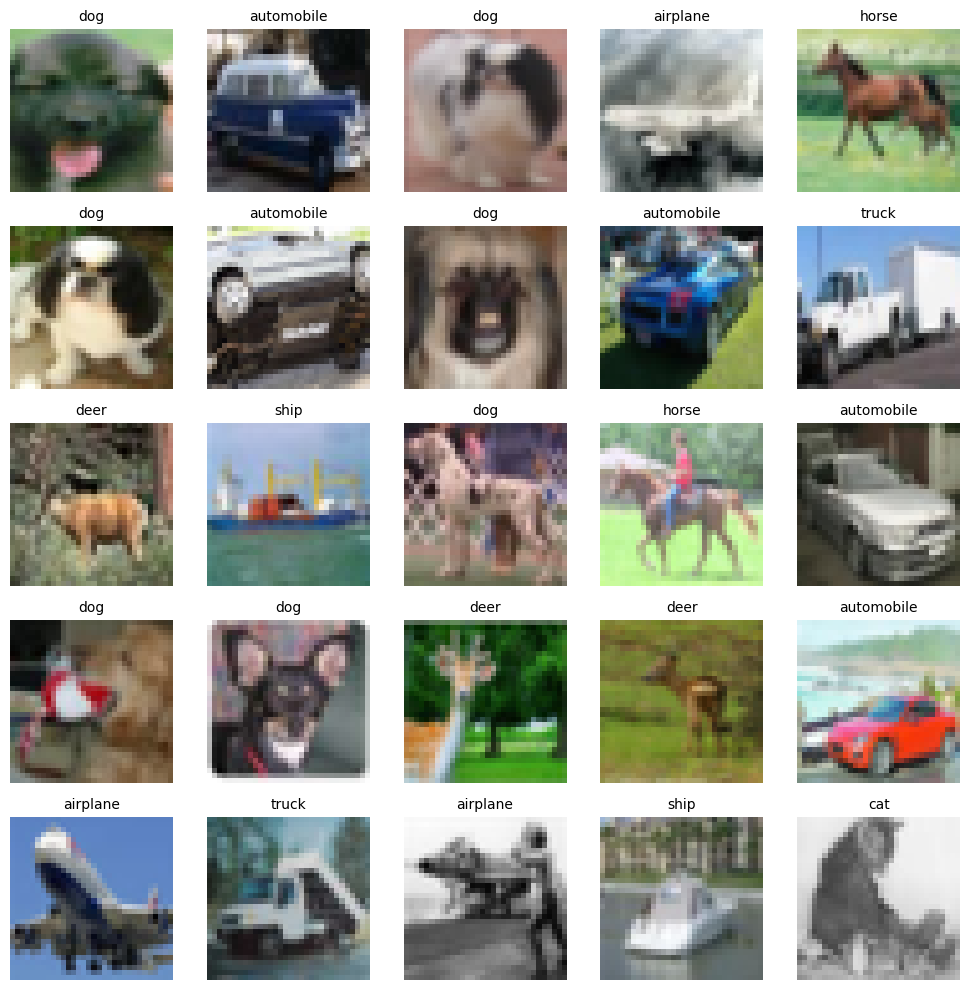

In [ ]:
plt.figure(figsize=(10, 10))

for i, img in enumerate(x_train[:25]):
    ax = plt.subplot(5, 5, i + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)

    if img.ndim == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)

    label = y_train[i]
    if hasattr(label, '__len__'):
        label = label[0]
    ax.set_title(nomes_classes[label], fontsize=10)

plt.tight_layout()
plt.show()

# **Imagens do Conjunto de Teste**

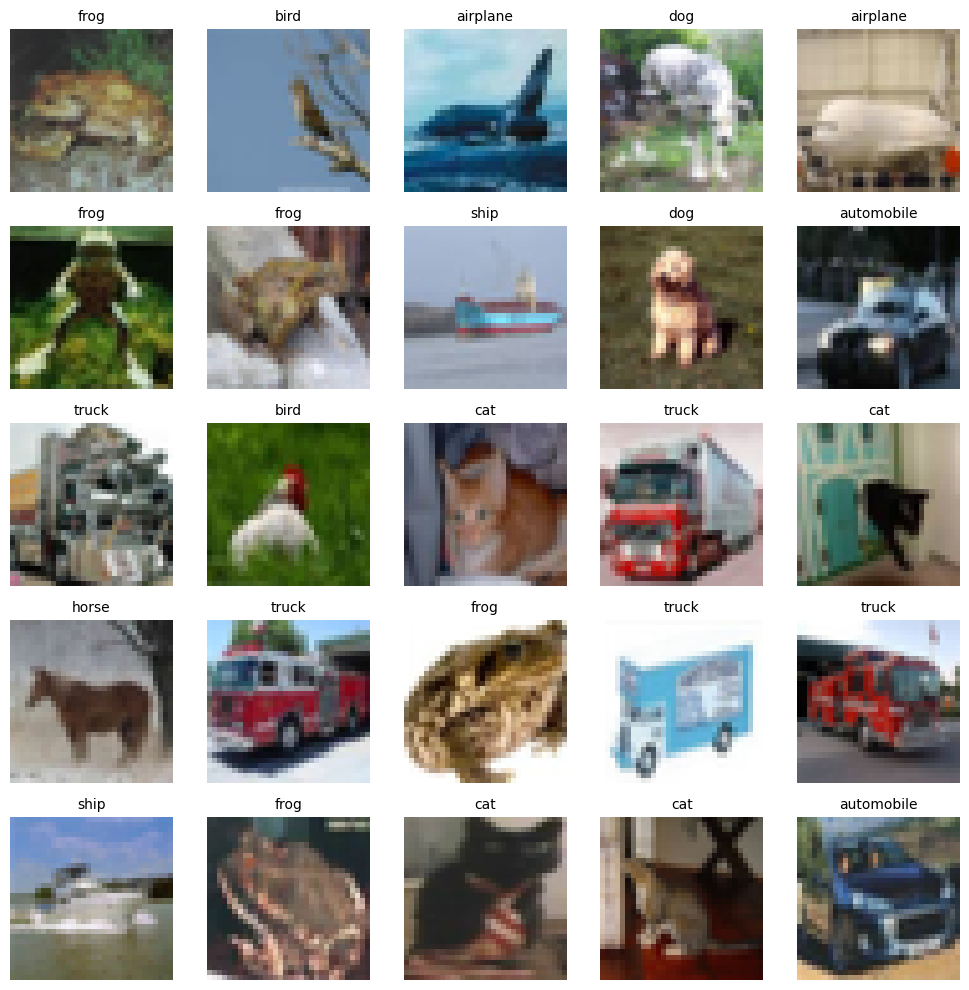

In [ ]:
plt.figure(figsize=(10, 10))

for i, img in enumerate(x_test[:25]):
    ax = plt.subplot(5, 5, i + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)

    if img.ndim == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)

    label = y_test[i]
    if hasattr(label, '__len__'):
        label = label[0]
    ax.set_title(nomes_classes[label], fontsize=10)

plt.tight_layout()
plt.show()

# **Rede Neural convolucional**

In [ ]:
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))


model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (32, 32, 3)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_38 (Activation)      │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 13, 13, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_39 (Activation)      │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 4, 4, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_40 (Activation)      │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_41 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_42 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │         2,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_43 (Activation)      │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,778 (471.79 KB)

 Trainable params: 120,778 (471.79 KB)

 Non-trainable params: 0 (0.00 B)

# **TREINO**

In [ ]:
#Adicionando uma Parada caso o val_loss não diminua durante 3 época, caso isso aconteça ele irá voltar os pesos da melhor época
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Parâmetros do Modelo
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(
    x_train, y_train_one_hot,
    batch_size=128,
    epochs=20,
    validation_data=(x_val, y_val_one_hot),
    callbacks=[early_stop]
)

Epoch 1/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.5509 - loss: 1.2556 - val_accuracy: 0.5917 - val_loss: 1.1196
Epoch 2/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5610 - loss: 1.2264 - val_accuracy: 0.6133 - val_loss: 1.1020
Epoch 3/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5641 - loss: 1.2158 - val_accuracy: 0.5937 - val_loss: 1.1085
Epoch 4/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5739 - loss: 1.1905 - val_accuracy: 0.6283 - val_loss: 1.0622
Epoch 5/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5757 - loss: 1.1875 - val_accuracy: 0.6251 - val_loss: 1.0435
Epoch 6/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5845 - loss: 1.1601 - val_accuracy: 0.6379 - val_loss: 1.0171
Epoch 7/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5875 - loss: 1.1531 - val_accuracy: 0.6311 - val_loss: 1.0312
Epoch 8/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5904 - loss: 1.1544 - val_accuracy: 

#Plotando a perda e a acurácia na validação

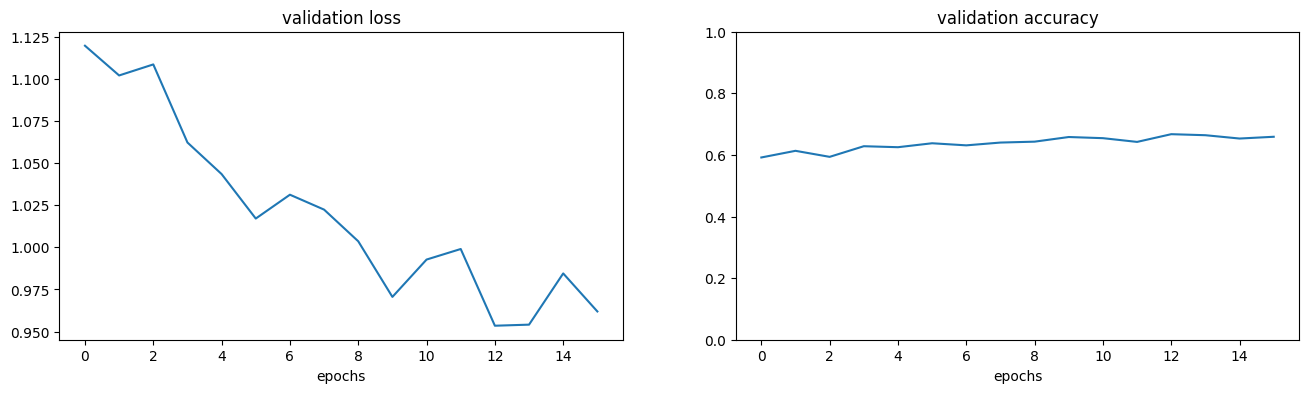

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

#**TESTE**

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test_one_hot, verbose=0)
print(f'Test loss: {loss:.2f}')
print(f'Test accuracy: {accuracy*100:.2f}%')

Test loss: 1.01
Test accuracy: 64.23%


# **VGG16**

In [ ]:
#adaptando a primeira camada para 32×32×3, no formato certo do nosso conjunto de dados
vgg_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(32, 32, 3)
)
#congelando todos os pesos
vgg_base.trainable = False

vgg_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
#Adaptando a última camada
x = vgg_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

model_new = Model(inputs=vgg_base.input, outputs=outputs)

In [ ]:
#Parâmetros do Novo Modelo
model_new.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_new.summary()

Model: "functional_152"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,982,474 (57.15 MB)

 Trainable params: 267,786 (1.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

# **TREINO**

In [ ]:
history2 = model_new.fit(
    x_train, y_train_one_hot,
    batch_size=128,
    epochs=20,
    validation_data=(x_val, y_val_one_hot),
    callbacks=[early_stop])

Epoch 1/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.4318 - loss: 1.6237 - val_accuracy: 0.5619 - val_loss: 1.2461
Epoch 2/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5722 - loss: 1.2249 - val_accuracy: 0.5788 - val_loss: 1.2037
Epoch 3/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5982 - loss: 1.1563 - val_accuracy: 0.5909 - val_loss: 1.1652
Epoch 4/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6110 - loss: 1.1077 - val_accuracy: 0.5935 - val_loss: 1.1617
Epoch 5/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6345 - loss: 1.0566 - val_accuracy: 0.6107 - val_loss: 1.1239
Epoch 6/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6482 - loss: 1.0119 - val_accuracy: 0.6040 - val_loss: 1.1299
Epoch 7/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.6558 - loss: 0.9924 - val_accuracy: 0.6188 - val_loss: 1.1025
Epoch 8/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6641 - loss: 0.9599 - val_

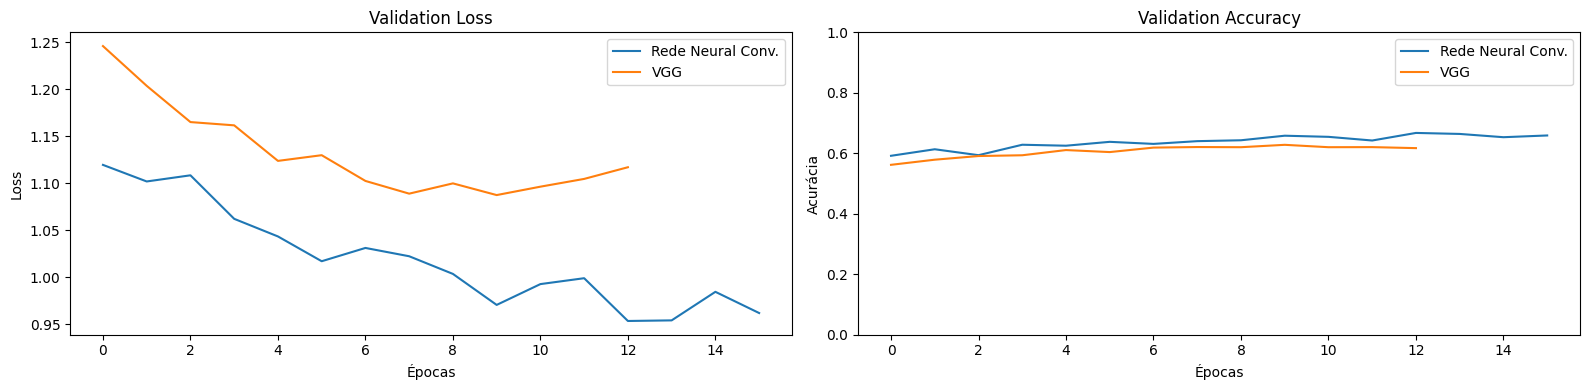

In [ ]:
fig = plt.figure(figsize=(16, 4))


ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"],  label='Rede Neural Conv.')
ax.plot(history2.history["val_loss"], label='VGG')
ax.set_title("Validation Loss")
ax.set_xlabel("Épocas")
ax.set_ylabel("Loss")
ax.legend()


ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"],  label='Rede Neural Conv.')
ax2.plot(history2.history["val_accuracy"], label='VGG')
ax2.set_title("Validation Accuracy")
ax2.set_xlabel("Épocas")
ax2.set_ylabel("Acurácia")
ax2.set_ylim(0, 1)
ax2.legend()

plt.tight_layout()
plt.show()

#**TESTE**

In [ ]:
loss, accuracy = model_new.evaluate(x_test, y_test_one_hot, verbose=0)

print(f'Test loss: {loss:.2f}')
print(f'Test accuracy: {accuracy*100:.2f}%')

Test loss: 1.09
Test accuracy: 62.77%
